# Term Deposits

Apziva project #2<br>
2023 06 28

__Summary:__
* A bank tries to convince their clients to __subscribe to a product: a term deposit__. This subscription, either "yes" or "no", is the ML target.
* Alongside their __marketing calls__, the callers collected __13 descriptors__ for each client, socio-economic factors as much as conversation-related data.
* As only about 7% of the clients finally subscribed to the product the dataset was __strongly imbalanced__. This stronlgy suggested to use __F1 as the metric__ to be used while evaluating the models, rather than the otherwise more common accuracy.
* Some effort was invested to identify the __start and the end of the marketing campaign__. With high probability, the marketing campaign startet mid-October 2014 and ended in August 2015. This finding allowed for interesting feature engineering.
* From four models evaluated, ridge regression yielded the best __F1 value: 0.451__.
* Surprisingly, __socio-economic features, loans and balance__ seem __not__ to be __relevant__ to the clients' readiness to subscribe to the product. Instead, subscriptions were more likely __the longer the marketing campaign lasted__, but not if the prolonged into the __last two months__ of the marketing campaign. Also a __long last talk__ points to a probable subscription.

## TOC: <a class="anchor" id="TOC"></a>
* [Task description](#TaskDescription)
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Data retrieval](#DataManagement)
* [EDA 1](#EDA)
    * [Basic data properties](#BasicDataProperties)
    * [Identifying year by contact counts](#IdentifyingYearByContactCounts)
    * [Identifying year by workdays](#IdentifyingYearByWorkdays)    
* [FE on date and weekday](#FEDateAndWeekday) 
* [EDA 2](#EDA2)
    * [Distributions and correlations](#Distributions)   
    * [Transformations](#Transformations)   
* [Dummy variables and train/test split](#DummyVariablesAndTrainTestSplit) 
* [EDA 3](#EDA3)
    * [Bi-plot](#BiPlot)  
* [Final dataset adjustments](#FinalDataSetAdjustments)
    * [Dummy variables](#DummyVariables)
    * [Interactions](#Interactions)
    * [Train/test split](#TrainTestSplit)  
* [Models](#Models)   
    * [Introduction to F1 score](#IntroductionToF1Score)   
    * [Baseline](#Baseline)   
    * [Logistic regression without regularization](#LogisticRegressionWithoutRegularization)   
    * [Lasso regression](#LassoRegression) 
    * [Ridge regression](#RidgeRegression)  
    * [Random forest](#RandomForest)      
* [Synopsis](#Synopsis)      
* [Conclusions](#Conclusions)     
    * [Feature importance](#FeatureImportance)  
    * [Model comparison](#ModelComparison)  

## Task description <a class="anchor" id="TaskDescription"></a>
[TOC](#TOC)

* Background:
    * We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and __customer intention prediction and classification__.
    * We are interested in developing a robust machine learning system that leverages information coming from __call center data__.
    * Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers __high success outcomes__ while offering __interpretability__ for our clients to make informed decisions.


* Data Description:
    * The data comes from __direct marketing efforts__ of a European banking institution. 
    * The marketing campaign involves making a __phone call__ to a customer, __often multiple times__ to ensure a __product subscription__, in this case a __term deposit__. 
    * Term deposits are usually short-term deposits with maturities ranging from one month to a few years. 
    * The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. 
    * All customer information that might reveal personal information is removed due to privacy concerns.


* Features:
    * __age__: age of customer (numeric)
    * __job__: type of job (categorical)
    * __marital__: marital status (categorical)
    * __education__ (categorical)
    * __default__: has credit in default? (binary)
    * __balance__: average yearly balance, in euros (numeric)
    * __housing__: has a housing loan? (binary)
    * __loan__: has personal loan? (binary)
    * __contact__: contact communication type (categorical)
    * __day__: last contact day of the month (numeric)
    * __month__: last contact month of year (categorical)
    * __duration__: last contact duration, in seconds (numeric)
    * __campaign__: number of contacts performed during this campaign and for this client (numeric, includes last contact)


* Target:
    * __y__: has the client subscribed to a term deposit? (binary)


* Goals:
    * Predict if the customer will __subscribe (yes/no) to a term deposit__ (variable y)


* Success metrics:
    * Hit __81% or above accuracy__ by evaluating with __5-fold cross validation__ and reporting the __average performance score__.


* Bonuses:
    * We are also interested in finding __customers who are more likely to buy the investment product__. 
    * Determine the __segment(s) of customers__ our client should __prioritize__.

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [98]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants
cfltRandomSeed = 42 # any number

cstrSourcePath = "../data/raw/"
cstrSourceFile = "term-deposit-marketing-2020.csv"
cintTestSize   = 5000

lstrMonthsOrdered = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

## Data retrieval <a class="anchor" id="DataManagement"></a>
[TOC](#TOC)

In [3]:
import pandas as pd

# get raw data
dfrRaw = pd.read_csv(f"{cstrSourcePath}/{cstrSourceFile}")
dfrRaw

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


# EDA <a class="anchor" id="EDA"></a>
[TOC](#TOC)

## Basic data properties <a class="anchor" id="BasicDataProperties"></a>
[TOC](#TOC)

In [4]:
u.DisplayDataFrame(dfrRaw.describe())
dfrRaw.info()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


__Observations:__
* No missing values.
* Numeric ranges:
    * age: reasonable.
    * balance: reasonable; negative values possible, rounded to integers 
    * day: reasonable.

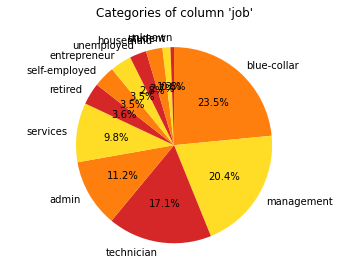

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64
Total count: 12



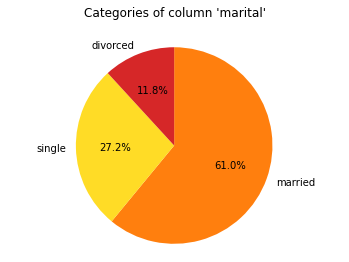

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64
Total count: 3



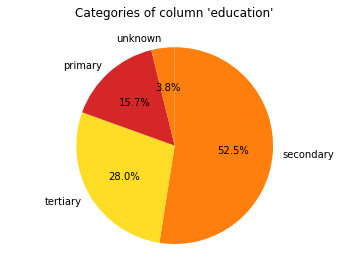

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64
Total count: 4



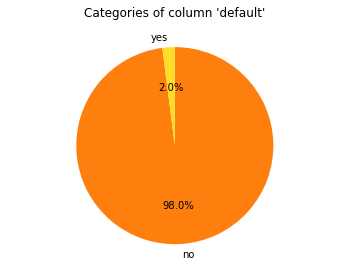

no     39191
yes      809
Name: default, dtype: int64
Total count: 2



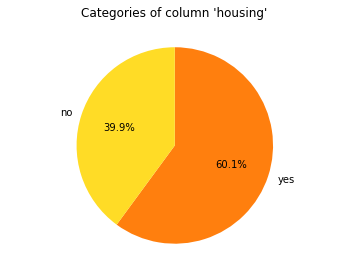

yes    24031
no     15969
Name: housing, dtype: int64
Total count: 2



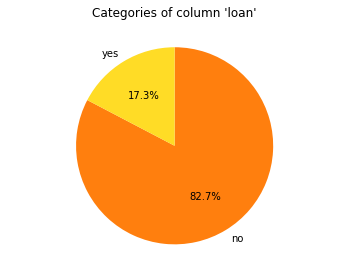

no     33070
yes     6930
Name: loan, dtype: int64
Total count: 2



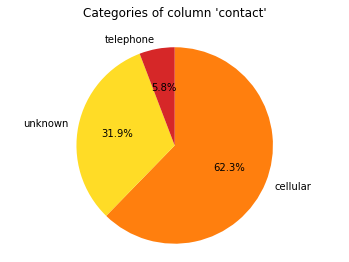

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64
Total count: 3



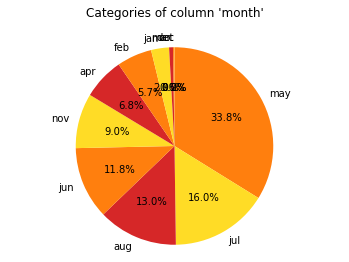

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64
Total count: 11



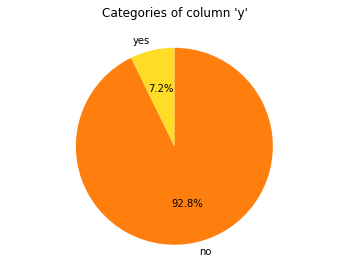

no     37104
yes     2896
Name: y, dtype: int64
Total count: 2



In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# reduce to the categorical columns
dfrCategoriesOnly = dfrRaw.select_dtypes(include=['object', 'category'])

# Iterate over each categorical column and print the categories and their counts
for strColumn in dfrCategoriesOnly:
    
    srsCategories = dfrRaw[strColumn].value_counts()
    
    # pie chart
    lstrColors = ["#FF7F0E", "#FFDC26","#D62728"]
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=lstrColors)
    plt.pie(srsCategories, labels=srsCategories.index, startangle=90, counterclock=False, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(f"Categories of column '{strColumn}'\n")
    plt.show()
    
    p(srsCategories)
    p(f"Total count: {len(srsCategories)}")
    p()

__Observations:__
* General:
    * No rare categories from misspelling or other variations from manual data entry (e.g. "service" or "phone" rather than "services" or "telephone"). For the rest of the project I will assume that categories have not to be mapped to pre-defined categories (using Levenshtein for example).
    * Missing values are coded using the string 'unknown'.
        * Occurrence:
            * yes: job, education.
            * no: marital, default, housing, loan, contact, month, y.
    * 'unknown' entries are not rare enough to drop the records entirely.
* Some categories are rare. 
    * Examples:
        * 'student' in 'job'
        * 'divorced' in 'marital'
        * 'primary' in 'education'
        * 'yes' in 'default'
        * 'telephone' in 'contact'
        * 'yes' in 'y'
    * The fact that 'y' is highly unbalanced will lead to a very high baseline:
        * 'no': 37,104 / 40,000 = 92.8%

__Decision how to handle 'unknown':__
* I lack of domain knowledge whether 'unknown' is a meaningful category or whether these entries should be filled with reasonable surrogate values.
* In a real project, I would talk to the customer to decide.
* There would be several options how to fill 'unknown', e.g. most frequent, nearby records, random, random/balanced.
* As the data set is generally in good shape, I tend to consider the category 'unknown' as meaningful:
    * Example: If a record does not have an entry at "job" this does not happen because the interviewer did not ask, but because the interviewee did not want to answer. 
    * Even if we do not know why the person did not answer this may be a clue whether this person will submit to the term deposit at the end of the day.

## Identifying year by contact counts <a class="anchor" id="IdentifyingYearByContactCounts"></a>
[TOC](#TOC)

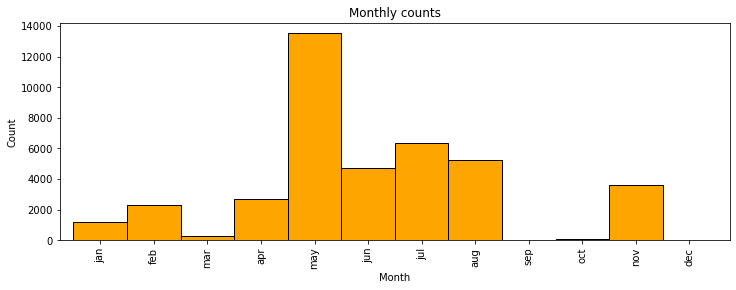

DISTRIBUTION OF DAYS:


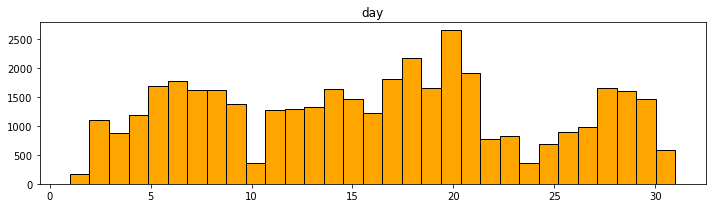

NUMBER OF CONTACTS BY MONTH OF LAST CONTACT:


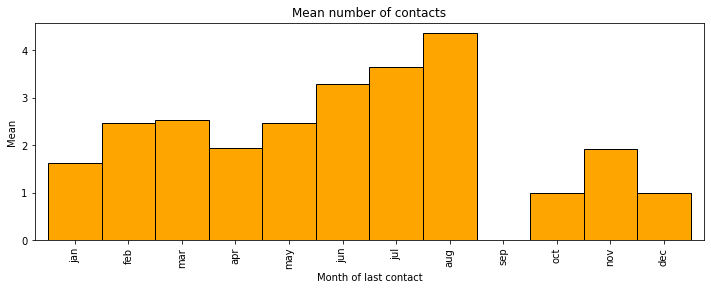

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
jan,1176.0,1.629252,0.873415,1.0,1.0,1.0,2.0,6.0
feb,2296.0,2.461237,2.102032,1.0,1.0,2.0,3.0,21.0
mar,258.0,2.523256,2.550929,1.0,1.0,2.0,3.0,19.0
apr,2718.0,1.945548,1.464328,1.0,1.0,1.0,2.0,23.0
may,13532.0,2.458912,2.489890,1.0,1.0,2.0,3.0,63.0
jun,4734.0,3.285805,4.099036,1.0,1.0,2.0,3.0,58.0
jul,6380.0,3.638558,4.394636,1.0,1.0,2.0,4.0,50.0
aug,5215.0,4.358198,3.942064,1.0,2.0,3.0,5.0,38.0
sep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# count occurrences of each month denomination
srsMonthColumn = dfrRaw["month"]
srsMonthCounts = srsMonthColumn.value_counts()
srsMonthCounts = srsMonthCounts.reindex(lstrMonthsOrdered)

# column diagram
fig, ax = plt.subplots(figsize=(12, 4))
srsMonthCounts.plot(kind="bar", ax=ax, color="orange", edgecolor="black", width=1.0)
ax.set_title("Monthly counts")
ax.set_xlabel("Month")
ax.set_ylabel("Count")
plt.show()

# days
p("Distribution of days:".upper())
ml.DrawDistributionPlots(dfrRaw,["day"],intDiagramColumns=1,intBins=31,fltTotalWidth=10,fltTotalHeight=3)

# number of contacts by month of last contact
p("Number of contacts by month of last contact:".upper())
srsContactsByLastMonth = dfrRaw.groupby("month")["campaign"]
dfrContactStatistics = srsContactsByLastMonth.describe()
dfrContactStatistics = dfrContactStatistics.reindex(lstrMonthsOrdered) # sort
fig, ax = plt.subplots(figsize=(12, 4))
dfrContactStatistics["mean"].plot(kind="bar", ax=ax, color="orange", edgecolor="black", width=1.0)
ax.set_title("Mean number of contacts")
ax.set_xlabel("Month of last contact")
ax.set_ylabel("Mean")
plt.show()
dfrContactStatistics

__Observations:__
* No 'year' column is given.
* May has most counts.
* None of the last contacts was in September. With 40K records we can assume that there is a reason behind the fact that there are no last contacts in September.
* When checking the number of contacts (```campaign```) vs. the month of the last contact (```month```), there seems to be a pattern:
    * The campaign seems to have started in October.
    * The campaign seems to have ended in August, containing those clients with most of the contacts

## Identifying year by workdays <a class="anchor" id="IdentifyingYearByWorkdays"></a>
[TOC](#TOC)

In [7]:
from datetime import datetime
def IsWorkday(intDay,strMonth,intYear,blnConsiderSaturdayAsWorkday=False):
    strDate = f"{intDay} {strMonth} {intYear}"
    intThreshold = 6 if blnConsiderSaturdayAsWorkday else 5
    try:
        objDateTime = datetime.strptime(strDate, "%d %b %Y")
        return int(objDateTime.weekday() < intThreshold)
    except:
        return -1 # e.g. "31 feb 2023"

pd.set_option('display.max_columns', 31)

lintYearCandidates = list(range(2012,2023))
lintYearCandidates.reverse()

for strMonth in lstrMonthsOrdered:
    dfrCurrMonth = pd.DataFrame({"Day":range(1,32)})
    dfrCurrMonth.set_index("Day", inplace=True)
    dfrCurrMonth["Count"] = 0

    for intYearCandidate in lintYearCandidates:
        dfrCurrMonth[f"Y{intYearCandidate}"] = 0
    for intDay in range(1,32):
        dfrCurrMonth["Count"].iloc[intDay-1] = len(dfrRaw[(dfrRaw["month"] == strMonth) & (dfrRaw["day"] == intDay)])
        for intYearCandidate in lintYearCandidates:
            dfrCurrMonth[f"Y{intYearCandidate}"].iloc[intDay-1] = IsWorkday(intDay,strMonth,intYearCandidate)
    p(strMonth. upper())
    u.DisplayDataFrame(dfrCurrMonth.T)
    
pd.reset_option('display.max_columns')    

JAN


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,394,534,248,0
Y2022,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2021,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2020,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2019,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2018,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2017,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2016,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2015,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2014,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1


FEB


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,504,314,432,414,241,0,0,194,24,19,9,19,0,0,15,29,19,7,0,0,0,0,0,0,20,36,0,0,0,0
Y2022,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1,-1,-1
Y2021,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,-1,-1,-1
Y2020,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1,-1
Y2019,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1,-1,-1
Y2018,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1,-1,-1
Y2017,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,-1,-1,-1
Y2016,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1,-1
Y2015,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1,-1,-1
Y2014,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,-1,-1,-1


MAR


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,28,20,3,24,6,0,0,7,19,14,14,4,0,0,9,13,10,3,1,0,0,7,12,6,11,22,0,0,17,8
Y2022,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2021,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2020,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2019,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2018,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2017,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2016,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2015,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2014,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1


APR


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,37,50,62,0,0,63,84,104,86,0,0,0,63,89,96,280,592,0,0,625,34,44,30,15,0,0,26,12,11,315,0
Y2022,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1
Y2021,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,-1
Y2020,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1
Y2019,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,-1
Y2018,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1
Y2017,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,-1
Y2016,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1
Y2015,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1
Y2014,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1


MAY


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,221,690,808,882,841,429,0,466,772,980,995,1125,391,0,629,339,384,438,74,435,0,92,562,563,533,442,441,0
Y2022,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2021,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2020,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2019,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2018,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2017,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2016,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2015,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2014,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0


JUN


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,86,504,408,254,359,398,0,0,319,0,229,192,0,0,0,287,333,274,288,608,0,0,16,18,30,45,50,0,0,36,0
Y2022,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1
Y2021,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1
Y2020,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,-1
Y2019,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,-1
Y2018,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1
Y2017,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,-1
Y2016,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1
Y2015,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,-1
Y2014,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1


JUL


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,53,23,70,91,0,0,346,342,334,313,209,0,0,283,247,233,286,259,0,0,366,313,328,304,301,0,0,357,350,393,579
Y2022,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2021,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2020,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2019,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2018,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2017,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2016,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2015,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2014,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1


AUG


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,173,193,257,299,328,0,0,328,295,248,262,0,0,0,269,317,278,241,334,0,0,265,256,266,348,258,0,0
Y2022,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2021,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2020,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2019,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2018,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2017,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2016,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2015,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2014,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0


SEP


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Y2022,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,-1
Y2021,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1
Y2020,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1
Y2019,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1
Y2018,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,-1
Y2017,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1
Y2016,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,-1
Y2015,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1
Y2014,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,-1


OCT


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,2,8,10,6,7,3,1,1,8,6,5,7,4
Y2022,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2021,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2020,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2019,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2018,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1
Y2017,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2016,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2015,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2014,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1


NOV


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,7,9,5,0,4,4,8,5,6,10,7,0,0,551,709,694,751,825,1,0,0,0,0,2,0,0,0,0
Y2022,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1
Y2021,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,-1
Y2020,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1
Y2019,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,-1
Y2018,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,-1
Y2017,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,-1
Y2016,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,-1
Y2015,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,-1
Y2014,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,-1


DEC


Day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Count,0,0,0,2,2,0,1,1,1,0,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
Y2022,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2021,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1
Y2020,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2019,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1
Y2018,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1
Y2017,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
Y2016,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0
Y2015,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1
Y2014,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1


__Workday patterns:__
* The workday patterns match best as follows:
    * jan: 2015
    * feb: 2015
    * mar: 2020, 2015
    * apr: 2015
    * may: 2020, 2015
    * jun: 2014
    * jul: 2014
    * aug: 2014
    * sep: no data
    * oct: 2014?
    * nov: 2014
    * dec: 2015, 2014, 2013
 * These matches would best account for a campaign start in June 2014, ending in May 2015.

__Decisions:__
* In a real project I would ask the customer.
* Pro's and con's:
    * Pro "June 2014 to May 2015":
        * Best work-day match.
    * Pro "October to August":
        * Rising mean number of calls.
        * Gap in September.
        * Gap first half of October.
* From this, I opt for "October to August", keeping in mind that this decision is based on debatable clues only.
* Finding the best year (see numeric analysis below):
    * February seems not to be in a leap year.
    * As above, the years 2014/2015 lead to the best workday pattern:
        * 2013/2014 tops 2014/2015 by 910 workdays.
        * 2014/2015 however, is the clear top leader for Sundays:
            * Under the 2014/2015 assumption, there are only 8 from 40,000 calls on Sundays.
            * I consider avoiding Sundays, but not necessarily avoiding Saturdays, a reasonable assumption.
* Thus, I will engineer a new feature named ```CampaignDay```.
* October 17th, 2014 will be set equal to 0. The true start of the campaign cannot be known, as only dates of the last contacts are recorded.
* I will add the week-day as an additional feature. The new feature shall be categorical, not an integer.

In [8]:
p("Workdays with different campaign starts:".upper())
for intCampaignStartYear in lintYearCandidates:
    intWorkdays = 0
    intWorkdaysPlusSaturdays = 0
    for intIndex, srsRow in dfrRaw.iterrows():
        intDay = srsRow["day"]
        strMonth = srsRow["month"]

        if strMonth in ["oct","nov","dec"]:
            intYear = intCampaignStartYear
        else:
            intYear = intCampaignStartYear + 1
            
        # Call the IsWorkDay function with the extracted values
        intWorkdays += IsWorkday(intDay, strMonth, intYear)
        intWorkdaysPlusSaturdays += IsWorkday(intDay, strMonth, intYear, blnConsiderSaturdayAsWorkday=True)
    p(f"Campaign {intCampaignStartYear}/{intCampaignStartYear+1}: {intWorkdays} workdays, {intWorkdaysPlusSaturdays} if Saturday included.")

WORKDAYS WITH DIFFERENT CAMPAIGN STARTS:
Campaign 2022/2023: 23653 workdays, 31422 if Saturday included.
Campaign 2021/2022: 23258 workdays, 31836 if Saturday included.
Campaign 2020/2021: 27292 workdays, 35456 if Saturday included.
Campaign 2019/2020: 34170 workdays, 38710 if Saturday included.
Campaign 2018/2019: 29063 workdays, 32692 if Saturday included.
Campaign 2017/2018: 24923 workdays, 32231 if Saturday included.
Campaign 2016/2017: 23653 workdays, 31422 if Saturday included.
Campaign 2015/2016: 25016 workdays, 33218 if Saturday included.
Campaign 2014/2015: 35448 workdays, 39992 if Saturday included.
Campaign 2013/2014: 36363 workdays, 36371 if Saturday included.
Campaign 2012/2013: 29063 workdays, 32692 if Saturday included.


# FE on date and weekday <a class="anchor" id="FEDateAndWeekday"></a>
[TOC](#TOC)

In [9]:
# add:
# - day since beginning of campaign
# - weekday of last contact
dfrDateEnriched = dfrRaw.copy()
dfrDateEnriched["CampaignDay"] = -1
dfrDateEnriched["Weekday"]     = ""
intCampaignStartYear = 2014
objCampaignStart = datetime(2014, 10, 17)

for intIndex, srsRow in dfrDateEnriched.iterrows():
    intDay = srsRow["day"]
    strMonth = srsRow["month"]
    if strMonth in ["oct","nov","dec"]:
        intYear = intCampaignStartYear
    else:
        intYear = intCampaignStartYear + 1

    objDateTime = datetime.strptime(f"{intDay} {strMonth} {intYear}", "%d %b %Y")
    objTimeDelta = objDateTime - objCampaignStart
    strWeekdayAbbreviation = datetime.strftime(objDateTime, "%a")
    dfrDateEnriched.at[intIndex, "CampaignDay"] = objTimeDelta.days
    dfrDateEnriched.at[intIndex, "Weekday"]     = strWeekdayAbbreviation

# column 'day' is of no use any more    
dfrDateEnriched = dfrDateEnriched.drop("day", axis=1)
dfrDateEnriched.head()    

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,y,CampaignDay,Weekday
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,no,200,Tue
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,no,200,Tue
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,no,200,Tue
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,no,200,Tue
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,no,200,Tue


CAMPAIGN PHASES


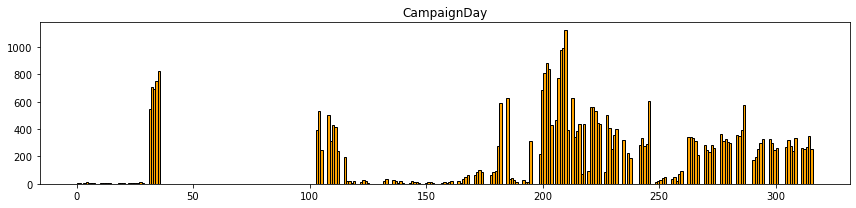

,count,mean,std,min,25%,50%,75%,max
CampaignDay,40000.0,208.5875,76.416568,0.0,195.0,215.0,267.0,316.0



ACTIVITY THROUGOUT THE WEEK


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Weekday,3629,7308,7769,8578,8164,4544,8


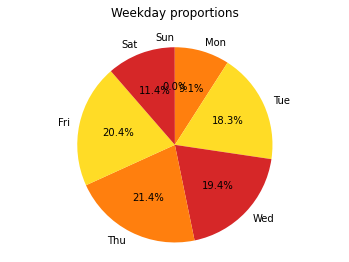

In [10]:
p("Campaign phases".upper())
ml.DrawDistributionPlots(dfrDateEnriched, ["CampaignDay"], intDiagramColumns=1, intBins=317,
    fltTotalWidth=12, fltTotalHeight=3
)
u.DisplayDataFrame(dfrDateEnriched[["CampaignDay"]].describe().T)
p()

# pie chart on week-days
p("Activity througout the week".upper())
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# preparations
srsWeekdayCounts = dfrDateEnriched["Weekday"].value_counts()
lstrWeekdaysOrdered = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
srsSortedWeekdayCounts = srsWeekdayCounts.loc[lstrWeekdaysOrdered]
lstrColors = ["#FF7F0E", "#FFDC26","#D62728"]
u.DisplayDataFrame(pd.DataFrame(srsSortedWeekdayCounts).T)

# pie chart
fig, ax = plt.subplots()
ax.pie(srsSortedWeekdayCounts, labels=srsSortedWeekdayCounts.index, startangle=90, counterclock=False, autopct="%1.1f%%", colors=lstrColors)
ax.axis("equal")
ax.set_title("Weekday proportions\n")

plt.show()

__Observations:__
* The campaign seems to have several contact phases:
    * Initial learning phase with few calls: probably adjusting the conversation strategy.
    * I first intense phase after about one month.
    * A two months' phase of only few calls. Maybe only calls initiated by the clients.
    * Another intense phase at about 3.5 months after the campaign start.
    * Regular activity, probably follow-up calls initiated by the bank.
* Days of the week:
    * There are about the same amount of calls on each work-day, except Monday, where the counts are lower.
    * On Saturdays, only about half as many calls as from Tuesday to Friday were executed.
    * Sunday calls are an exception, under my assumption that the campaign started in October 2014.

# EDA 2 <a class="anchor" id="EDA2"></a>
[TOC](#TOC)

## Distributions and correlations <a class="anchor" id="Distributions"></a>
[TOC](#TOC)

DATE-ENRICHED DATA


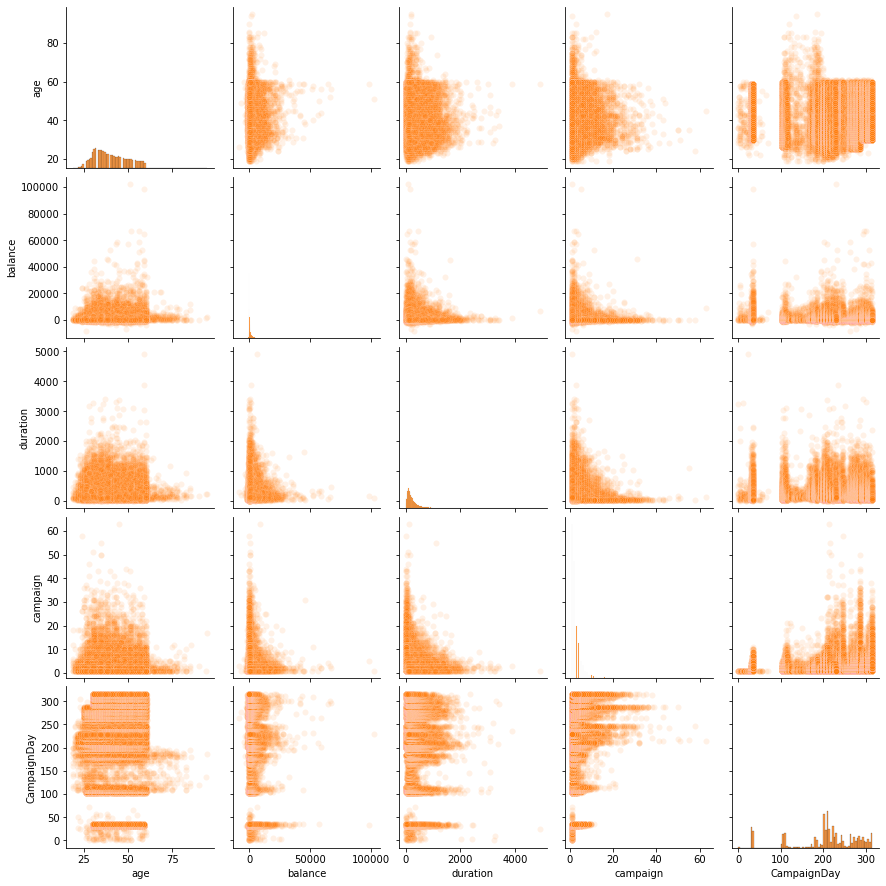

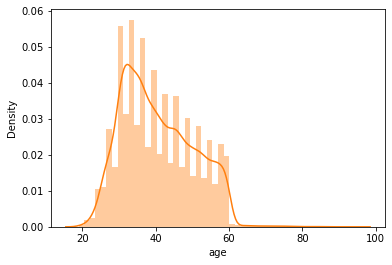

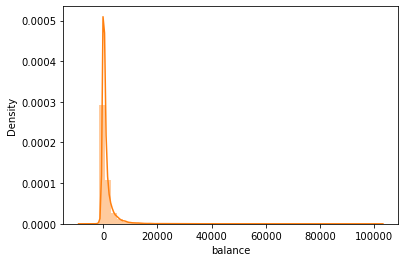

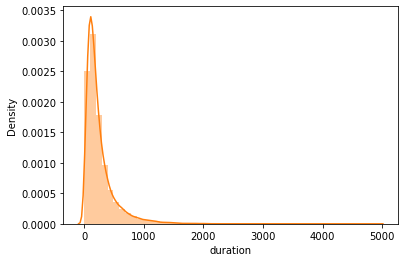

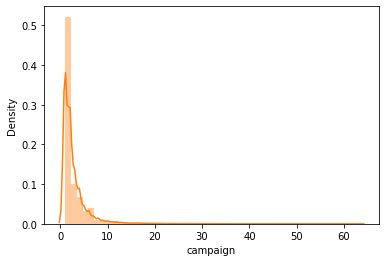

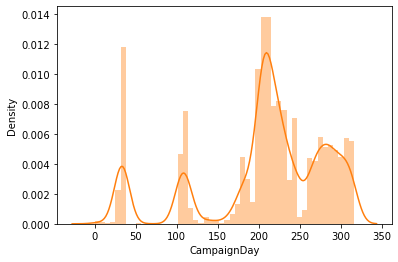

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

def Pairplot (dfrSource,strTitle=""):
    
    # title
    strTitle = "Pair-plot" if strTitle=="" else strTitle
    p(strTitle.upper())
    
    # numeric columns only
    dfrNumericColumns = dfrSource.select_dtypes(include=['float64', 'int64'])

    # correlation matrix
    dfrCorrelationMatrix = dfrNumericColumns.corr()

    # correlation scattergrams
    sns.pairplot(dfrNumericColumns, plot_kws={'alpha':0.1})
    plt.show()

    # distributions of each numeric column
    warnings.filterwarnings("ignore", category=FutureWarning)
    for strColumn in dfrNumericColumns.columns:
        sns.distplot(dfrNumericColumns[strColumn])
        plt.show()
    warnings.resetwarnings()    
    
Pairplot(dfrDateEnriched,"Date-enriched data")   

__Remarks:__
* Distributions:
    * __age__: Almost all clients are 20 to 60 years of age, with a peak at about 30 years.
    * __balance__: There is a small negative tail and a large positive tail.
    * __duration__: The duration of the last phone call cannot be negative, but there is long tail up to about 1.5 hours (positive skew).
    * __campaign__: Most clients were contacted 10 times or less, but there is long right-hand tail (positive skew).
    * __CampaignDay__: There are about four campaign phases (see more detailed analysis further above).
* Correlations:
    * No obvious pairwise correlation among the numeric variables

## Transformations <a class="anchor" id="Transformations"></a>
[TOC](#TOC)

__Starting point:__
* The features `balance`, `duration` and `campaign` have a positive skew, which should be addressed.
* Candidates like sqrt or log do not work for `balance` as there are negative values.
* The __Yeo-Johnson transformation__ is documented as being able to cope with negative values.

ACTUAL SKEWNESSES WITHIN DATA:
- 'balance': 8.26
- 'duration': 3.17
- 'campaign': 4.73

EXPERIMENTAL YEO-JOHNSON TRANSFORMATIONS:


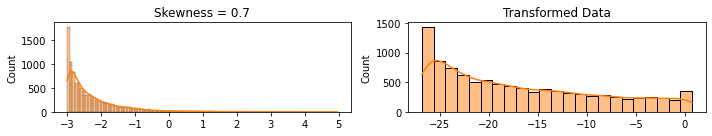

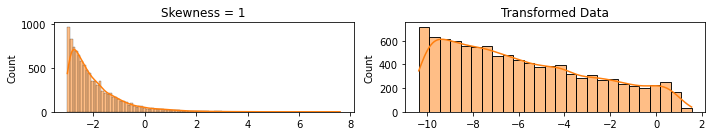

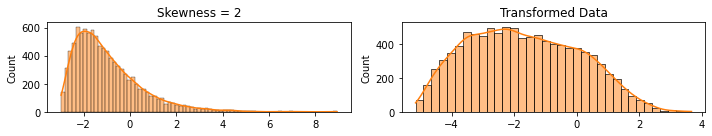

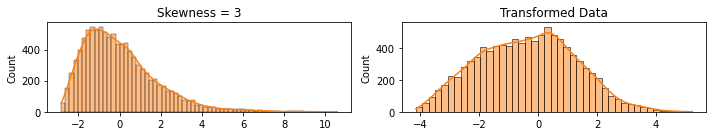

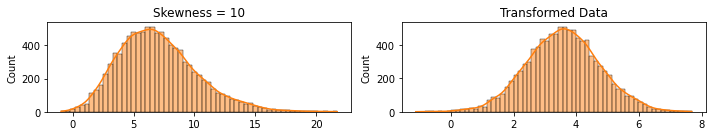

In [12]:
from scipy import stats

p("Actual skewnesses within data:".upper())
for strColumn in ['balance','duration','campaign']:
    fltSkewness = dfrDateEnriched[strColumn].skew()
    p(f"- '{strColumn}':", round(fltSkewness,2))
p()

# examples
p("Experimental Yeo-Johnson transformations:".upper())
for fltExperimentalSkewness in [0.7,1,2,3,10]:
    
    # experimental data
    afltOriginalData = np.random.gamma(shape=fltExperimentalSkewness, scale=1, size=10000)-3

    # Yeo-Johnson transformation
    afltTransformedData, lambda_value = stats.yeojohnson(afltOriginalData)

    # distribution plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))
    for intIndex,strLabel in enumerate([f"Skewness = {fltExperimentalSkewness}","Transformed Data"]):
        afltData = afltOriginalData if intIndex==0 else afltTransformedData
        sns.histplot(afltData, kde=True, ax=axes[intIndex])
        axes[intIndex].set_title(strLabel)

    # finalize
    plt.tight_layout()
    plt.show()

__Remarks and decision:__
* The skewnesses I am dealing with are 3.17 or higher.
* The Yeo-Johnson transformation has some problems with skewnesses below 3, but seems to work fine with the actual skewnesses.
* I check the Yeo-Johnson transformation on the columns `balance`, `duration` and`campaign`. I also check the more conventional log and sqrt transformations.

LOGARITHM, SHIFTED


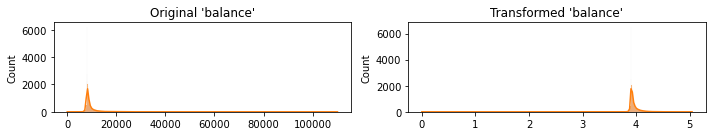

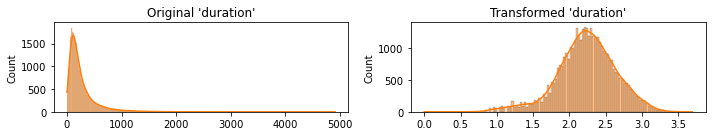

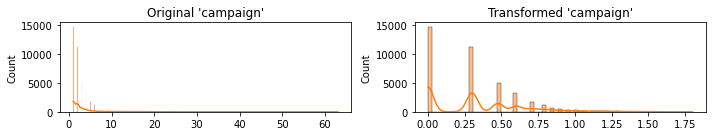

SQUARE ROOT, SHIFTED


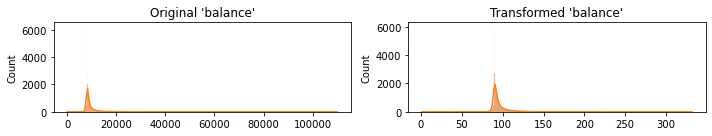

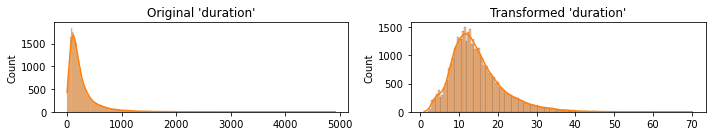

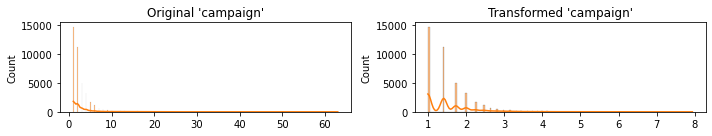

YEO-JOHNSON


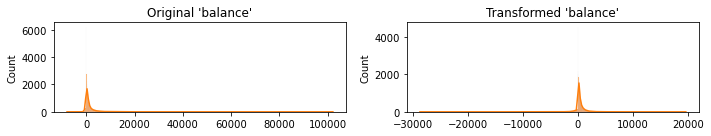

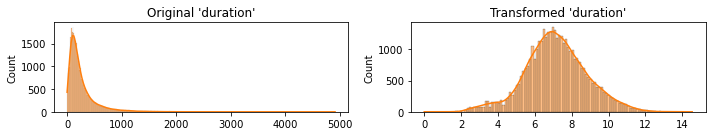

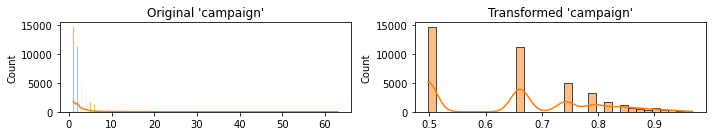

In [13]:
from scipy import stats
dfrTransformed = dfrDateEnriched.copy()

for intIndex,strTransformation in enumerate(["Logarithm","Square root","Yeo-Johnson"]):
    
    # init transformation
    if intIndex in [0,1]:
        strTransformation = f"{strTransformation}, shifted"
    p(strTransformation.upper())
    
    for strColumn in ['balance','duration','campaign']:

        # get data
        afltOriginalData = np.array(dfrTransformed[strColumn])
        
        # shifting
        if intIndex in [0,1]:
            afltShiftedData = afltOriginalData - np.min(afltOriginalData) + 1
        else:
            afltShiftedData = afltOriginalData # no shifting
        
        # transformation
        if intIndex == 0:
            afltTransformedData = np.log10(afltShiftedData) 
        elif intIndex == 1:
            afltTransformedData = np.sqrt(afltShiftedData)             
        elif intIndex == 2:
            afltTransformedData, lambda_value = stats.yeojohnson(afltShiftedData)
        
        dfrTransformed[f"{strColumn}_trans"] = afltTransformedData

        # distribution plots
        fig, axes = plt.subplots(1, 2, figsize=(10, 2))
        for intPlotIndex,strLabel in enumerate([f"Original '{strColumn}'",f"Transformed '{strColumn}'"]):
            afltData = afltShiftedData if intPlotIndex==0 else afltTransformedData
            sns.histplot(afltData, kde=True, ax=axes[intPlotIndex])
            axes[intPlotIndex].set_title(strLabel)

        # finalize
        plt.tight_layout()
        plt.show()

__Remarks:__
* The Yeo-Johnson transformation result is as follows:
    * good for `duration`.
    * At least symmetrical for `balance`.
    * Still bad for `campaign`, but the values get closer (i.e. less extrem tail).
* `log`and `sqrt` are the same or worse.
* Thus, I will use Yeo-Johnson.

In [15]:
dfrTransformed.drop(["balance","duration","campaign"], axis=1, inplace=True)
dfrTransformed.head()

,age,job,marital,education,default,housing,loan,contact,month,y,CampaignDay,Weekday,balance_trans,duration_trans,campaign_trans
0,58,management,married,tertiary,no,yes,no,unknown,may,no,200,Tue,755.822325,7.843324,0.497164
1,44,technician,single,secondary,no,yes,no,unknown,may,no,200,Tue,19.621581,6.832794,0.497164
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,no,200,Tue,1.807345,5.657526,0.497164
3,47,blue-collar,married,unknown,no,yes,no,unknown,may,no,200,Tue,561.422564,5.974490,0.497164
4,33,unknown,single,unknown,no,no,no,unknown,may,no,200,Tue,0.941190,7.324821,0.497164


TRANSFORMED DATA


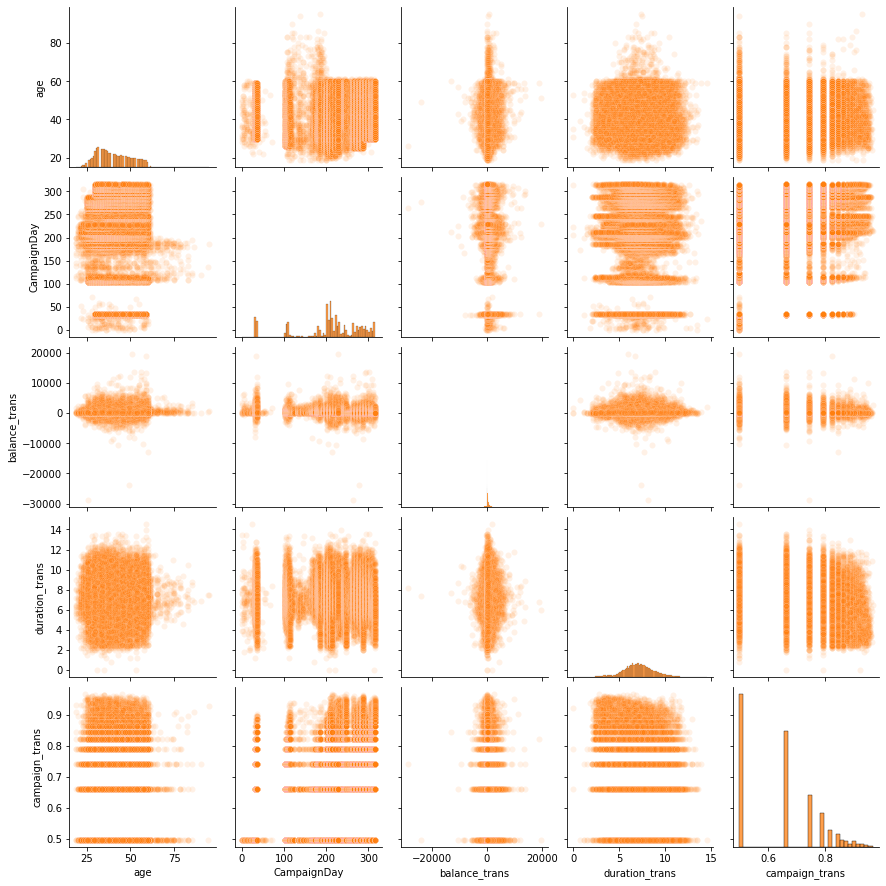

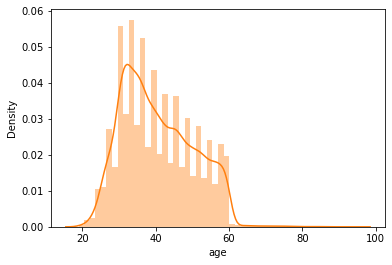

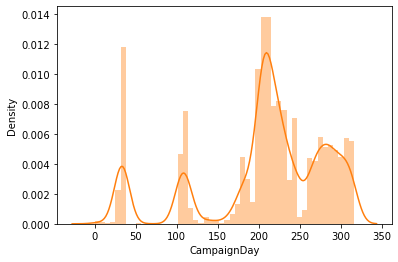

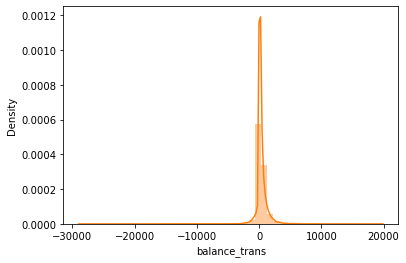

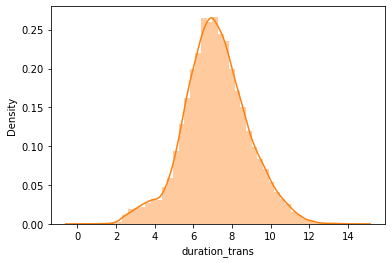

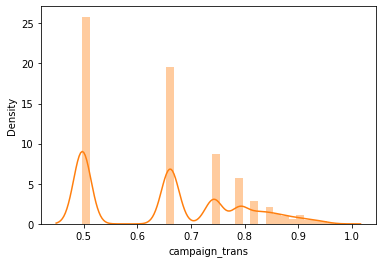

In [16]:
Pairplot(dfrTransformed,"Transformed data")

__Comments:__
* After transforming some of the columns there are still no correlations.

# Final dataset adjustments <a class="anchor" id="FinalDataSetAdjustments"></a>
[TOC](#TOC)

## Dummy variables<a class="anchor" id="DummyVariables"></a>
[TOC](#TOC)

In [17]:
dfrTransformed.head()

,age,job,marital,education,default,housing,loan,contact,month,y,CampaignDay,Weekday,balance_trans,duration_trans,campaign_trans
0,58,management,married,tertiary,no,yes,no,unknown,may,no,200,Tue,755.822325,7.843324,0.497164
1,44,technician,single,secondary,no,yes,no,unknown,may,no,200,Tue,19.621581,6.832794,0.497164
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,no,200,Tue,1.807345,5.657526,0.497164
3,47,blue-collar,married,unknown,no,yes,no,unknown,may,no,200,Tue,561.422564,5.974490,0.497164
4,33,unknown,single,unknown,no,no,no,unknown,may,no,200,Tue,0.941190,7.324821,0.497164


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# create dummy columns
dfrDummies = dfrTransformed.copy()
dfrDummies['y'] = dfrDummies['y'].replace({'no': 0, 'yes': 1})
lstrCategoricalColumns = list(dfrDummies.select_dtypes(include='object').columns)
dfrDummies = pd.get_dummies(dfrDummies, columns=lstrCategoricalColumns)
p("Features after creating dummies:" , dfrDummies.shape[1] - 1)
p("Data rows:" , dfrDummies.shape[0])

Features after creating dummies: 51
Data rows: 40000


## Interactions <a class="anchor" id="Interactions"></a>
[TOC](#TOC)

__Considerations:__
* With 40,000 data rows and only 51 features, there is no risk of the "curse of dimensionality".
* Instead, there is room for more features, e.g. interactions.
* How to decide which interactions to add:
    * I do not have domain knowledge to individually select feature pairs which could be good candidates.
    * An (uninformed) guess may be that interactions among the socio-economic features `age`, `job`, `marital` and `education` are possible.
    * Rather than guessing, I apply all possible pairwise interactions and check the dimensionality.

In [19]:
dfrInteractions = dfrDummies.copy()

import itertools

# get feature pairs
dfrFeatureColumns = dfrInteractions.columns.drop('y')  
ltstrFeaturePairs = list(itertools.combinations(dfrFeatureColumns, 2))

# add interactions
for strFeature1, strFeature2 in ltstrFeaturePairs:
    strInteractionColumn = f"{strFeature1}_x_{strFeature2}"
    dfrInteractions[strInteractionColumn] = dfrInteractions[strFeature1] * dfrInteractions[strFeature2]
p("Features after adding pairwise interactions:" , dfrInteractions.shape[1] - 1)

# delete rows containing 0's only
dfrInteractions = dfrInteractions.loc[:, (dfrInteractions != 0).any(axis=0)] 
p("Features after deleting columns with 0's only:" , dfrInteractions.shape[1] - 1)

C:\Users\domin\AppData\Local\Temp\ipykernel_5892\569997636.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfrInteractions[strInteractionColumn] = dfrInteractions[strFeature1] * dfrInteractions[strFeature2]


Features after adding pairwise interactions: 1326
Features after deleting columns with 0's only: 1123


__New considerations:__
* A feature array 40,000 x 1123 could be used, but will have an impact on computational times.
* I check what happens when limiting the interactions to the socio-economic features `age`, `job`, `marital` and `education` are possible.

In [20]:
dfrInteractions = dfrDummies.copy()

import itertools

# filter socio-economic features
dfrFeatureColumns = dfrInteractions.columns.drop('y')  
lstrFeatures = list(dfrFeatureColumns)
lstrStartChunksForSocioEconomicFeatures = ["age", "job", "marital", "education"]
lstrSocioEconomicFeatures = [strFeature for strFeature in lstrFeatures if any(strFeature.startswith(strChunk) for strChunk in lstrStartChunksForSocioEconomicFeatures)]

# add interactions
ltstrFeaturePairs = list(itertools.combinations(lstrSocioEconomicFeatures, 2))

# add interactions
for strFeature1, strFeature2 in ltstrFeaturePairs:
    strInteractionColumn = f"{strFeature1}_x_{strFeature2}"
    dfrInteractions[strInteractionColumn] = dfrInteractions[strFeature1] * dfrInteractions[strFeature2]
p("Features after adding pairwise interactions:" , dfrInteractions.shape[1] - 1)

# delete rows containing 0's only
dfrInteractions = dfrInteractions.loc[:, (dfrInteractions != 0).any(axis=0)] 
p("Features after deleting columns with 0's only:" , dfrInteractions.shape[1] - 1)

Features after adding pairwise interactions: 241
Features after deleting columns with 0's only: 166


C:\Users\domin\AppData\Local\Temp\ipykernel_5892\4118064417.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfrInteractions[strInteractionColumn] = dfrInteractions[strFeature1] * dfrInteractions[strFeature2]


__Final considerations on interactions:__
* I tried some of the models using this reduced amount of interactions.
* Computational times were prolonged, but I could not detect any improvements in the models.
* Thus, I continue with the dataset without interactions

In [21]:
blnUsingInteractions = False
if blnUsingInteractions:
    dfrReady = dfrInteractions.copy()
else:
    dfrReady = dfrDummies.copy()
    
p("Final dataset, ready for modeling:")
dfrReady

Final dataset, ready for modeling:


,age,y,CampaignDay,balance_trans,duration_trans,campaign_trans,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
0,58,0,200,755.822325,7.843324,0.497164,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,44,0,200,19.621581,6.832794,0.497164,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,33,0,200,1.807345,5.657526,0.497164,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
3,47,0,200,561.422564,5.974490,0.497164,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,33,0,200,0.941190,7.324821,0.497164,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,229,181.451403,6.230541,0.497164,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39996,30,1,229,1098.531281,7.668256,0.742569,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39997,54,1,229,102.011207,7.045989,0.497164,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39998,34,0,229,413.200321,8.367564,0.497164,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Train/test split <a class="anchor" id="TrainTestSplit"></a>
[TOC](#TOC)

In [22]:
# split train / test
X = dfrReady.drop('y', axis=1) 
y = dfrReady['y']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=cintTestSize, stratify=y, random_state=cfltRandomSeed)
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

# checks
p("Shapes of data sets:".upper())
p("- train:", X_train.shape, y_train.shape)
p("- test: ", X_test.shape, y_test.shape)

SHAPES OF DATA SETS:
- train: (35000, 51) (35000,)
- test:  (5000, 51) (5000,)


# EDA 3 <a class="anchor" id="EDA3"></a>
[TOC](#TOC)

## Bi-plot <a class="anchor" id="BiPlot"></a>
[TOC](#TOC)

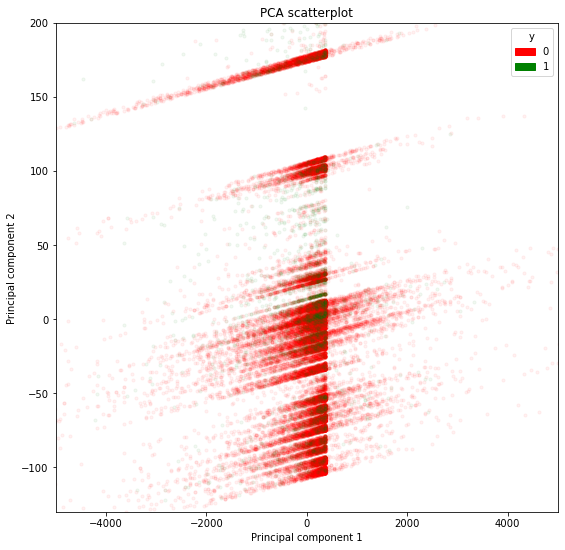

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# run PCA
cintComponents = 2
objPCA = PCA(n_components=cintComponents)
X_pca = objPCA.fit_transform(X_train) # or: "a2fltXFromPCA"
dfrPCA = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
dfrPCA['y'] = y_train

# scatterplot
cfltDotSize = 10
cfltPlotWidth = 9
cfltPlotHeight = 9
lstrColors = ['red', 'green']
lintTargetLabels = [0, 1]
plt.figure(figsize=(cfltPlotWidth, cfltPlotHeight))
legend_patches = []
for lintTargetLabel, strColor in zip(lintTargetLabels, lstrColors):
    dfrSubset = dfrPCA[dfrPCA['y'] == lintTargetLabel]
    plt.scatter(dfrSubset['PC1'], dfrSubset['PC2'], color=strColor, alpha=0.05, s=cfltDotSize, label=lintTargetLabel)
    legend_patch = mpatches.Patch(color=strColor, alpha=1.0, label=lintTargetLabel)
    legend_patches.append(legend_patch)
    
# finalize plot
plt.xlim(-5000, +5000)
plt.ylim( -130,  +200)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PCA scatterplot')
plt.legend(handles=legend_patches, title='y')
plt.show()

__Comments:__
* Most target "yes" (i.e. `y=1`) have __PC1 ranging from 0 to 400__, seemingly independent of PC2.
* `PC1=400` seems to be a __density threshold__ for both target categories, "yes" and "no".
* The binary target categories do not build two distinct clouds, instead there seems to be a __strong overlay__.
* From this bi-plot, it does not seem trivial to separate the two target categories.
* However, much information may have been lost, reducing X from 51 features to only 2 principal components.
* In a former run __with interactions__ (i.e. 166 features) the result was __visually identical__.

# Models <a class="anchor" id="Models"></a>
[TOC](#TOC)

## Introduction to F1 score <a class="anchor" id="IntroductionToF1Score"></a>
[TOC](#TOC)

* The __F1 score__ is a measure of a model's accuracy in binary classification tasks, which __combines both precision and recall__ into a single metric. It is the harmonic mean of precision and recall, providing a balanced assessment of a model's performance.
* Precision is the ratio of true positive predictions to the total number of positive predictions. It measures the accuracy of positive predictions, indicating how many of the predicted positive instances are actually correct. Precision is calculated as:
    * __Precision__ = TP / (TP + FP)
* Recall, also known as __sensitivity__ or true positive rate, is the ratio of true positive predictions to the total number of actual positive instances. It measures the ability of the model to correctly identify positive instances. Recall is calculated as:
    * __Recall__ = TP / (TP + FN)
* In scenarios with __unbalanced data__, where the number of instances in different classes is significantly imbalanced, __accuracy alone__ may __not__ be a __reliable__ performance metric. For example, if 95% of the instances belong to the negative class, a model that predicts all instances as negative would achieve a high accuracy, but it would __fail to capture the minority positive class__.
* In such cases, the __F1 score__ becomes __crucial__ because it considers both precision and recall, enabling a balanced evaluation of the model's performance. By incorporating both metrics, the F1 score is especially useful when dealing with __imbalanced datasets__ because it rewards models that can __achieve a balance__ between correctly identifying positive instances (recall) and minimizing false positives (precision). It provides a single value that summarizes the model's effectiveness in dealing with imbalanced data, helping to assess its overall performance.
    * __F1__ = 2 * (precision * sensitivity) / (precision + sensitivity)
    * __F1__ = 2 * TP / (2 * TP + FP + FN)

## Baseline <a class="anchor" id="Baseline"></a>
[TOC](#TOC)

In [109]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score

def CalculateBaseline(y_train, y_test):

    # dummy classifier using the 'most_frequent' strategy
    objDummyClassifier = DummyClassifier(strategy='most_frequent')

    # fit and predict the dummy model
    objDummyClassifier.fit(y_train, y_train)
    y_train_baseline = objDummyClassifier.predict(y_train)
    y_test_baseline  = objDummyClassifier.predict(y_test)

    # calculate baseline metrics
    fltModelBaselineF1 = f1_score(y_test, y_test_baseline)
    fltModelBaselineAccuracy = accuracy_score(y_test, y_test_baseline)

    return fltModelBaselineF1, fltModelBaselineAccuracy

# example:
p("Baseline".upper())
p()
p("Artificial example with 90% in the 'most frequent' class".upper())
y_train_example = np.array([0] * 90 + [1] * 10)
y_test_example  = np.array([0] *  9 + [1] *  1)
fltModelBaselineF1, fltModelBaselineAccuracy = CalculateBaseline(y_train_example, y_test_example)
p("- F1:", fltModelBaselineF1)
p("- accuracy:", fltModelBaselineAccuracy)
p()

# project data
p("Project data".upper())
fltModelBaselineF1, fltModelBaselineAccuracy = CalculateBaseline(y_train, y_test)
p("- F1:", fltModelBaselineF1)
p("- accuracy:", fltModelBaselineAccuracy)

# save
u.ToDisk(fltModelBaselineF1,strType="models")

BASELINE

ARTIFICIAL EXAMPLE WITH 90% IN THE 'MOST FREQUENT' CLASS
- F1: 0.0
- accuracy: 0.9

PROJECT DATA
- F1: 0.0
- accuracy: 0.9276


__Comments:__
* The accuracy is pretty high, because the target is imbalanced.
* The F1 score reveals that the baseline model has no reasonable meaning.

## Logistic regression without regularization <a class="anchor" id="LogisticRegressionWithoutRegularization"></a>
[TOC](#TOC)

In [110]:
# weights
def DisplayTopWeights(dfltWeights,strColumn,intTopExamples=15):
    dfrWeights = pd.DataFrame(dfltWeights)
    strAbsColumn = f"{strColumn}_abs"
    dfrWeights[strAbsColumn] = dfrWeights[strColumn].abs()
    dfrWeights.sort_values(strAbsColumn, ascending=False,inplace=True)
    dfrWeights.drop(strAbsColumn,axis=1,inplace=True)
    p(f"Top {intTopExamples} weights:".upper())
    u.DisplayDataFrame(dfrWeights.head(intTopExamples))
    
lstrFeatureNames = list(dfrReady.columns.drop("y"))
dfltWeights = {"Feature": lstrFeatureNames}

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

u.StopWatch()

# init
lstrFeatureNames = list(dfrReady.columns.drop("y"))

try:
    fltModelLogisticRegressionF1 = u.FromDisk("fltModelLogisticRegressionF1", strType="models")
    objModelLogisticRegressionF1 = u.FromDisk("objModelLogisticRegressionF1", strType="models")
    
except:
    
    # scale data
    objStandardScaler = StandardScaler()
    X_train_scaled = objStandardScaler.fit_transform(X_train)
    X_test_scaled = objStandardScaler.transform(X_test)

    # logistic regression
    objModelLogisticRegressionF1 = LogisticRegression(penalty='none', solver="saga", max_iter=5000)
    objModelLogisticRegressionF1.fit(X_train_scaled, y_train)

    # predictions and F1 score
    y_pred = objModelLogisticRegressionF1.predict(X_test_scaled)
    fltModelLogisticRegressionF1 = f1_score(y_test, y_pred)

# report results
p("Logistic regression".upper())
p("F1 score:", round(fltModelLogisticRegressionF1))
lfltWeights = list(objModelLogisticRegressionF1.coef_.flatten())
dfltWeights["No regularization"] = lfltWeights

# save
u.ToDisk(fltModelLogisticRegressionF1, strType="models")
u.ToDisk(objModelLogisticRegressionF1, strType="models")

u.StopWatch("minutes",intDigits=1)

LOGISTIC REGRESSION
F1 score: 0
0.6 minutes


In [112]:
DisplayTopWeights(dfltWeights,"No regularization")

TOP 15 WEIGHTS:


,Feature,No regularization
1,CampaignDay,2.555837
3,duration_trans,2.040133
42,month_nov,1.449688
34,month_aug,-1.351176
38,month_jul,-1.114512
36,month_feb,0.803828
43,month_oct,0.524018
32,contact_unknown,-0.505984
40,month_mar,0.429059
30,contact_cellular,0.418886


## Lasso regression <a class="anchor" id="LassoRegression"></a>
[TOC](#TOC)

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

u.StopWatch()

try:
    objGridSearchLasso = u.FromDisk("objModelLassoF1",strType="models")
    
except:
    
    # pipeline and hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LogisticRegression(penalty='l1', solver='saga'))
    ])
    
    if (True):
        dvarHyperparameters = {
            'lasso__random_state': [cfltRandomSeed],
            'lasso__C': [1, 10,100,1000],  # regularization
            'lasso__max_iter': [50,100, 200]
        }
    else:  # debugging
        dvarHyperparameters = {
            'lasso__random_state': [cfltRandomSeed],
            'lasso__C': [100],  # regularization
            'lasso__max_iter': [100]
        }

    # grid search with cross-validation
    objGridSearchLasso = GridSearchCV(pipeline, dvarHyperparameters, cv=5, scoring='f1')
    objGridSearchLasso.fit(X_train, y_train)

# get and evaluate best model
objModelLassoF1 = objGridSearchLasso.best_estimator_
intBestMaxIter = objGridSearchLasso.best_estimator_.named_steps['lasso'].max_iter
fltBestScore = objGridSearchLasso.best_score_
y_pred = objModelLassoF1.predict(X_test)
fltModelLassoF1 = f1_score(y_test, y_pred)

# remember weights
a1fltRegressionParameters = objModelLassoF1.named_steps['lasso'].coef_
dfltWeights["Lasso"] = a1fltRegressionParameters.flatten()

# output
p("Best model:           ", objModelLassoF1)
p("Best max_iter:        ", intBestMaxIter)
p("Best F1 score (CV):   ", round(fltBestScore,3))
p("Test F1 score:        ", round(fltModelLassoF1,3))
p()
DisplayTopWeights(dfltWeights,"Lasso")

# save
u.ToDisk(fltModelLassoF1,   strType="models")
u.ToDisk(objGridSearchLasso,"objModelLassoF1",strType="models")

# time used
u.StopWatch("minutes",intDigits=1)

C:\Users\domin\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\domin\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\domin\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\domin\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\domin\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\domin\anaconda3\envs\capstone\l

Best model:            Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='saga'))])
Best max_iter:         100
Best F1 score (CV):    0.393
Test F1 score:         0.435

TOP 15 WEIGHTS:


C:\Users\domin\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Feature,No regularization,Lasso
3,duration_trans,2.040133,2.016999
32,contact_unknown,-0.505984,-0.466125
34,month_aug,-1.351176,-0.421393
1,CampaignDay,2.555837,0.381122
38,month_jul,-1.114512,-0.380106
30,contact_cellular,0.418886,0.375567
40,month_mar,0.429059,0.295548
39,month_jun,0.048238,0.288587
43,month_oct,0.524018,0.272076
37,month_jan,0.261322,-0.229668


2.8 minutes


## Ridge regression <a class="anchor" id="RidgeRegression"></a>
[TOC](#TOC)

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

u.StopWatch()

try:
    objGridSearchRidge = u.FromDisk("objModelRidgeF1",strType="models")
    
except:
    
    # pipeline and hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', LogisticRegression(penalty='l2', solver='saga'))
    ])
    
    if (True):
        dvarHyperparameters = {
            'ridge__random_state': [cfltRandomSeed],
            'ridge__C': [0.1, 1, 10,100,1000],  # regularization
            'ridge__max_iter': [5000]
        }
    else: # debugging
        dvarHyperparameters = {
            'ridge__random_state': [cfltRandomSeed],
            'ridge__C': [100],  # regularization
            'ridge__max_iter': [100]
        }

    # grid search with cross-validation
    objGridSearchRidge = GridSearchCV(pipeline, dvarHyperparameters, cv=5, scoring='f1')
    objGridSearchRidge.fit(X_train, y_train)

# get and evaluate best model
objModelRidgeF1 = objGridSearchRidge.best_estimator_
intBestMaxIter = objGridSearchRidge.best_estimator_.named_steps['ridge'].max_iter
fltBestScore = objGridSearchRidge.best_score_
y_pred = objModelRidgeF1.predict(X_test)
fltModelRidgeF1 = f1_score(y_test, y_pred)

# remember weights
a1fltRegressionParameters = objModelRidgeF1.named_steps['ridge'].coef_
dfltWeights["Ridge"] = a1fltRegressionParameters.flatten()

# output
p("Best model:           ", objModelRidgeF1)
p("Best max_iter:        ", intBestMaxIter)
p("Best F1 score (CV):   ", round(fltBestScore,3))
p("Test F1 score:        ", round(fltModelRidgeF1,3))
p()
DisplayTopWeights(dfltWeights,"Ridge")

# save
u.ToDisk(fltModelRidgeF1,   strType="models")
u.ToDisk(objGridSearchRidge,"objModelRidgeF1",strType="models")

# time used
u.StopWatch("minutes",intDigits=1)

Best model:            Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 LogisticRegression(C=100, max_iter=5000, random_state=42,
                                    solver='saga'))])
Best max_iter:         5000
Best F1 score (CV):    0.394
Test F1 score:         0.451

TOP 15 WEIGHTS:


,Feature,No regularization,Lasso,Ridge
1,CampaignDay,2.555837,0.381122,2.551678
3,duration_trans,2.040133,2.016999,2.040050
42,month_nov,1.449688,0.048948,1.447017
34,month_aug,-1.351176,-0.421393,-1.349382
38,month_jul,-1.114512,-0.380106,-1.113089
36,month_feb,0.803828,0.181097,0.802640
43,month_oct,0.524018,0.272076,0.523533
32,contact_unknown,-0.505984,-0.466125,-0.505882
40,month_mar,0.429059,0.295548,0.428801
30,contact_cellular,0.418886,0.375567,0.418804


12.6 minutes


## Random forest <a class="anchor" id="RandomForest"></a>
[TOC](#TOC)

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

u.StopWatch()

try:
    objModelRandomForestF1 = u.FromDisk("objModelRandomForestF1",strType="models")
    fltF1Value             = u.FromDisk("fltModelRandomForestF1",strType="models")
except:
    # parameter grid
    if (True): # productive
        objParameterGrid = {
            'n_estimators': [30,50,80],
            'max_depth': [15,20,30]
        }
    else: # debugging
        objParameterGrid = {
            'n_estimators': [100],
            'max_depth': [10]
        }

    # random forest model
    objRandomForestClassifier = RandomForestClassifier(random_state=cfltRandomSeed)

    # grid search with cross-validation
    objRandomForestGridSearch = GridSearchCV(objRandomForestClassifier, objParameterGrid, cv=5, scoring='f1')
    objRandomForestGridSearch.fit(X_train, y_train)

# get the best model and its performance
objBestModel = objRandomForestGridSearch.best_estimator_
y_pred = objBestModel.predict(X_test)
fltF1Value = f1_score(y_test, y_pred)

# report
p("Summary".upper())
p("\nBest Parameters:", objRandomForestGridSearch.best_params_)
p("F1 Score:", round(fltF1Value,3))

# save
u.ToDisk(objRandomForestGridSearch,"objModelRandomForestF1",strType="models")
u.ToDisk(fltF1Value,"fltModelRandomForestF1",strType="models")

u.StopWatch("minutes",1)

SUMMARY

Best Parameters: {'max_depth': 20, 'n_estimators': 50}
F1 Score: 0.416
1.1 minutes


# Synopsis <a class="anchor" id="Synopsis"></a>
[TOC](#TOC)

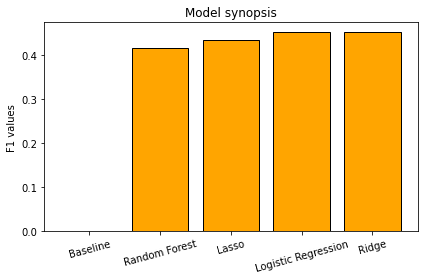

In [141]:
import os
### import pickle
import re
import matplotlib.pyplot as plt

# get all files from the pickle directory
strResultDirectory = "../models"
lstrFiles = os.listdir(strResultDirectory)

# filter F1 files
strFilenamePattern = r"fltModel([A-Za-z]+)F1\.p"
lstrFilteredFiles = [strFile for strFile in lstrFiles if re.match(strFilenamePattern, strFile)]

# read files as float numbers
dfltF1Values = {}
for strFile in lstrFilteredFiles:    
    strModelName = re.match(strFilenamePattern, strFile).group(1)
    strVariableName = strFile[:-2]
    dfltF1Values[strModelName] = u.FromDisk(strVariableName)
dfltF1Values = u.SortDictionaryByValue(dfltF1Values, varAscending=True)
                      
# collect values and labels
lstrLabels = []
lfltF1Values = []
for strName, fltF1Value in dfltF1Values.items():
    lstrLabels.append(re.sub(r'([a-z])([A-Z])', r'\1 \2', strName))  # Add space in camel-case labels
    lfltF1Values.append(fltF1Value)

# column diagram
fig, ax = plt.subplots()
ax.bar(lstrLabels, lfltF1Values, color='orange', edgecolor='black')

# finalize plot
ax.set_xlabel("")
ax.set_ylabel('F1 values')
ax.set_title ('Model synopsis')
plt.xticks(rotation=15) 
plt.tight_layout() 
plt.show()

# Conclusions <a class="anchor" id="Conclusions"></a>
[TOC](#TOC)

## Feature importance <a class="anchor" id="FeatureImportance"></a>
[TOC](#TOC)

__General:__
* Logistic regression models yield similar feature importances, independent from regularization.

__Details:__
* Time relative to the bank's campaign:
    * The __later in the campaign__ the last talk takes place, the more probable it leads to a subscription.
    * If the last talk is during the __first half year__ of the campaign (October to April) this often leads to a subscription. Late subscribers seem to be rare (July and August). That is, in the future, after about half a year there is little value to put more effort into convincing subscribers.
    * The above two points are __contradictory__. This may point to a non-linear relationship, i.e. both very early and very late subscribers are rare.
    * We must consider the fact that we do not know when a client was __contacted for the first time__. We cannot assume that all cients were contacted right at the beginning of the campaign. If another similar campaign ist launched, one might suggest the bank to collect different data, e.g. days from first to last conversation or total conversation time.
* A __long last talk__ is points to a subscription. However, we do not know, if a long last talk convinces clients. Or, instead, if a convinced client needs a long last talk.
* Clients using __cellphones__ are more prone to subscribe than clients using landline telephone communication.
* Surprisingly, __socio-economic features, loans and balance__ seem __not__ to be __relevant__ to the outcome.

## Model comparison <a class="anchor" id="ModelComparison"></a>
[TOC](#TOC)

__Summary:__
* All models reach F1 values between __0.41 and 0.46__.
* Random forest is the weakest, __ridge regression__ the __best model__ with `F1 = 0.451`.
* The __parametric models__ are slightly __better__ than the non-parametric random forest model.
    * Non-parametric models are often better when non-linear relationships are involved.
* Beside the good performance of the ridge regression, the weights can also be used to estimate __feature importance__.
    * This would not be straightforward with the random forest model.